# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

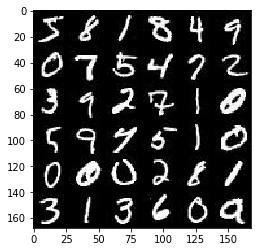

In [2]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

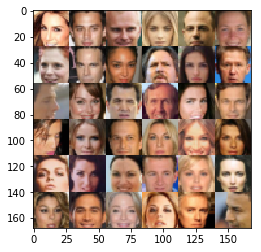

In [3]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


/Users/Beck/anaconda/envs/tflearn/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [15]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(
        tf.float32, 
        [None, image_width, image_height, image_channels], 
        name="input_real")
    inputs_z = tf.placeholder(
        tf.float32, 
        [None, z_dim], 
        name="input_z")
    learning_rate = tf.placeholder(tf.float32, [], name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [80]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x64
        
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, 2, 'same')
        batch_norm1 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm1, batch_norm1)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, 2, 'same')
        batch_norm2 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm2, batch_norm2)
        # 4x4x256
        
        conv4 = tf.layers.conv2d(lrelu3, 512, 5, 2, 'same')
        batch_norm3 = tf.layers.batch_normalization(conv4, training=True)
        lrelu4 = tf.maximum(alpha * batch_norm3, batch_norm3)
        # 2x2x512
       
        # Flatten it
        flat = tf.reshape(lrelu4, (-1, 2*2*512))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [81]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    if is_train==True:
        reuse = False
    else:
        reuse = True
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=reuse):
        # First fully connected layer
        fc1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        reshape = tf.reshape(fc1, (-1, 4, 4, 512))
        batch_norm1 = tf.layers.batch_normalization(reshape, training=is_train)
        lrelu1 = tf.maximum(alpha * batch_norm1, batch_norm1)
        print('LRELU1', lrelu1.shape)

        deconv1 = tf.layers.conv2d_transpose(lrelu1, 256, 4, strides=1, padding='valid')
        batch_norm2 = tf.layers.batch_normalization(deconv1, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        print('LRELU2', lrelu2.shape)
        # 4x4x256
        
        deconv2 = tf.layers.conv2d_transpose(lrelu2, 128, 5, 2, 'same')
        batch_norm3 = tf.layers.batch_normalization(deconv2, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        print('LRELU3', lrelu3.shape)
        # 7x7x128
        
        
        deconv3 = tf.layers.conv2d_transpose(lrelu3, 64, 5, 2, 'same')
        batch_norm4 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        print('LRELU4', lrelu4.shape)
        # 14x14x64
        
        # Logits
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 3, 1, 'same')
        # Output
        output = tf.tanh(logits)
        
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [34]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    # Build the model
    g_model = generator(input_z, out_channel_dim)
    # g_model is the generator output
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

LRELU1 (?, 2, 2, 256)
LRELU2 (?, 4, 4, 128)
LRELU3 (?, 7, 7, 64)
LRELU4 (?, 14, 14, 32)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [35]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Optimizers

    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    if data_image_mode == "L":
        out_channel_dim = 1
    else:
        out_channel_dim = 3
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                print(batch_images)
                batch_images *= 2 
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt,
                             feed_dict={input_z: batch_z,
                                        input_real: batch_images,
                                        learn_rate: learning_rate})
                _ = sess.run(g_train_opt, 
                             feed_dict={input_z: batch_z, 
                                        input_real: batch_images,
                                        learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train = False),
                                   feed_dict={input_z: batch_z})
                    
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
Epoch 1/2... Discriminator Loss: 1.8356... Generator Loss: 0.2985
Epoch 1/2... Discriminator Loss: 0.4483... Generator Loss: 2.5116
Epoch 1/2... Discriminator Loss: 0.8117... Generator Loss: 4.0055
Epoch 1/2... Discriminator Loss: 0.3551... Generator Loss: 7.2864
Epoch 1/2... Discriminator Loss: 0.4581... Generator Loss: 3.1539
Epoch 1/2... Discriminator Loss: 0.3594... Generator Loss: 4.2503
Epoch 1/2... Discriminator Loss: 0.3947... Generator Loss: 3.0239
Epoch 1/2... Discriminator Loss: 0.9075... Generator Loss: 7.2942
Epoch 1/2... Discriminator Loss: 0.4987... Generator Loss: 2.2849
Epoch 1/2... Discriminator Loss: 0.3975... Generator Loss: 7.6534
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


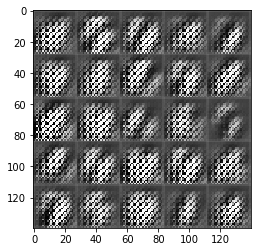

Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 1.0436
Epoch 1/2... Discriminator Loss: 0.6198... Generator Loss: 1.9645
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 1.3977
Epoch 1/2... Discriminator Loss: 2.7610... Generator Loss: 0.1514
Epoch 1/2... Discriminator Loss: 1.4140... Generator Loss: 0.5124
Epoch 1/2... Discriminator Loss: 0.5237... Generator Loss: 2.7710
Epoch 1/2... Discriminator Loss: 0.5210... Generator Loss: 2.8307
Epoch 1/2... Discriminator Loss: 0.7504... Generator Loss: 1.6825
Epoch 1/2... Discriminator Loss: 0.8003... Generator Loss: 1.2848
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


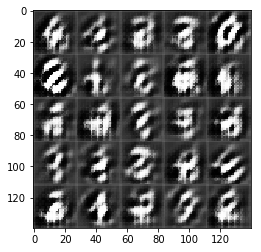

Epoch 1/2... Discriminator Loss: 0.8421... Generator Loss: 1.5692
Epoch 1/2... Discriminator Loss: 1.2622... Generator Loss: 2.4552
Epoch 1/2... Discriminator Loss: 0.9400... Generator Loss: 1.1544
Epoch 1/2... Discriminator Loss: 1.3461... Generator Loss: 0.7422
Epoch 1/2... Discriminator Loss: 0.8554... Generator Loss: 1.2680
Epoch 1/2... Discriminator Loss: 0.8431... Generator Loss: 3.2706
Epoch 1/2... Discriminator Loss: 0.9961... Generator Loss: 1.2151
Epoch 1/2... Discriminator Loss: 1.3177... Generator Loss: 0.6786
Epoch 1/2... Discriminator Loss: 1.4270... Generator Loss: 0.4981
Epoch 1/2... Discriminator Loss: 1.0885... Generator Loss: 0.8542
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


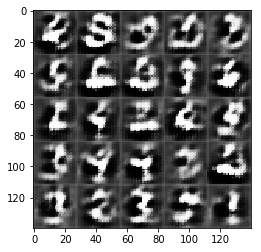

Epoch 1/2... Discriminator Loss: 0.8623... Generator Loss: 1.4063
Epoch 1/2... Discriminator Loss: 1.4271... Generator Loss: 0.5005
Epoch 1/2... Discriminator Loss: 0.6375... Generator Loss: 2.2959
Epoch 1/2... Discriminator Loss: 0.9177... Generator Loss: 1.3416
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 2.7865
Epoch 1/2... Discriminator Loss: 0.8932... Generator Loss: 1.0397
Epoch 1/2... Discriminator Loss: 0.9522... Generator Loss: 1.1853
Epoch 1/2... Discriminator Loss: 0.7294... Generator Loss: 1.3540
Epoch 1/2... Discriminator Loss: 1.3294... Generator Loss: 0.6547
Epoch 1/2... Discriminator Loss: 0.9418... Generator Loss: 1.3012
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


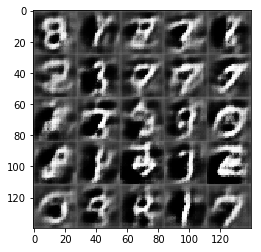

Epoch 1/2... Discriminator Loss: 0.9291... Generator Loss: 1.4787
Epoch 1/2... Discriminator Loss: 0.9107... Generator Loss: 1.9132
Epoch 1/2... Discriminator Loss: 0.8966... Generator Loss: 1.2787
Epoch 1/2... Discriminator Loss: 1.2689... Generator Loss: 0.6436
Epoch 1/2... Discriminator Loss: 0.8513... Generator Loss: 1.1866
Epoch 1/2... Discriminator Loss: 1.0272... Generator Loss: 1.1365
Epoch 1/2... Discriminator Loss: 1.0080... Generator Loss: 1.2276
Epoch 1/2... Discriminator Loss: 1.3501... Generator Loss: 0.5777
Epoch 1/2... Discriminator Loss: 0.9759... Generator Loss: 0.9614
Epoch 1/2... Discriminator Loss: 1.1110... Generator Loss: 0.8248
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


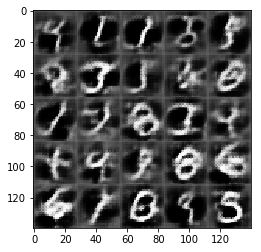

Epoch 1/2... Discriminator Loss: 1.1265... Generator Loss: 1.5878
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 0.8752
Epoch 1/2... Discriminator Loss: 0.9307... Generator Loss: 1.2016
Epoch 1/2... Discriminator Loss: 1.1038... Generator Loss: 2.1113
Epoch 1/2... Discriminator Loss: 1.1553... Generator Loss: 0.8555
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 0.7375
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 1.0299... Generator Loss: 0.9111
Epoch 1/2... Discriminator Loss: 1.1564... Generator Loss: 1.3700
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 1.1398
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


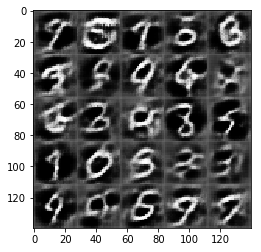

Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.7655
Epoch 1/2... Discriminator Loss: 0.9033... Generator Loss: 1.7003
Epoch 1/2... Discriminator Loss: 0.9889... Generator Loss: 0.9956
Epoch 1/2... Discriminator Loss: 0.9425... Generator Loss: 1.1716
Epoch 1/2... Discriminator Loss: 1.0614... Generator Loss: 1.2386
Epoch 1/2... Discriminator Loss: 0.8731... Generator Loss: 1.1499
Epoch 1/2... Discriminator Loss: 0.9432... Generator Loss: 1.0575
Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 0.8873
Epoch 1/2... Discriminator Loss: 0.8647... Generator Loss: 1.2274
Epoch 1/2... Discriminator Loss: 0.8824... Generator Loss: 1.0592
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


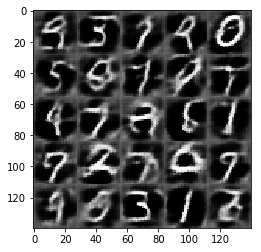

Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 0.9878
Epoch 1/2... Discriminator Loss: 1.8747... Generator Loss: 0.2933
Epoch 1/2... Discriminator Loss: 1.0724... Generator Loss: 0.8597
Epoch 1/2... Discriminator Loss: 0.8685... Generator Loss: 1.4603
Epoch 1/2... Discriminator Loss: 0.8631... Generator Loss: 1.5380
Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 0.6030
Epoch 1/2... Discriminator Loss: 1.0170... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 1.4601
Epoch 1/2... Discriminator Loss: 1.4377... Generator Loss: 0.5312
Epoch 1/2... Discriminator Loss: 0.9280... Generator Loss: 0.9911
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


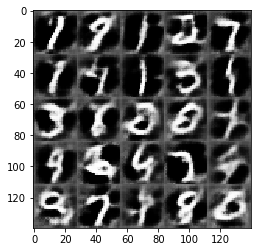

Epoch 1/2... Discriminator Loss: 0.9504... Generator Loss: 0.9315
Epoch 1/2... Discriminator Loss: 1.2934... Generator Loss: 2.2577
Epoch 1/2... Discriminator Loss: 1.1280... Generator Loss: 1.5661
Epoch 1/2... Discriminator Loss: 0.9508... Generator Loss: 1.0142
Epoch 1/2... Discriminator Loss: 0.7530... Generator Loss: 1.3282
Epoch 1/2... Discriminator Loss: 2.9499... Generator Loss: 0.1358
Epoch 1/2... Discriminator Loss: 1.1606... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.1801... Generator Loss: 0.7264
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 1.0761
Epoch 1/2... Discriminator Loss: 0.9188... Generator Loss: 1.2350
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


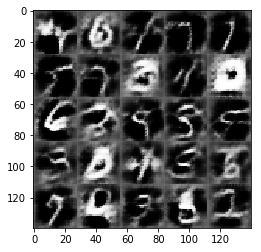

Epoch 1/2... Discriminator Loss: 1.2132... Generator Loss: 0.6453
Epoch 1/2... Discriminator Loss: 0.8446... Generator Loss: 1.5098
Epoch 1/2... Discriminator Loss: 1.0704... Generator Loss: 1.0837
Epoch 2/2... Discriminator Loss: 0.9029... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 0.8353... Generator Loss: 1.4545
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 0.9349
Epoch 2/2... Discriminator Loss: 0.8998... Generator Loss: 1.1221
Epoch 2/2... Discriminator Loss: 0.8478... Generator Loss: 1.6783
Epoch 2/2... Discriminator Loss: 1.5448... Generator Loss: 0.4764
Epoch 2/2... Discriminator Loss: 1.1384... Generator Loss: 0.6851
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


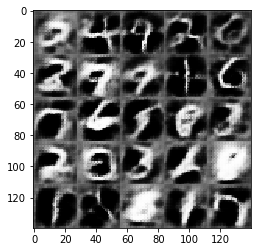

Epoch 2/2... Discriminator Loss: 0.8822... Generator Loss: 1.2740
Epoch 2/2... Discriminator Loss: 0.9868... Generator Loss: 1.0846
Epoch 2/2... Discriminator Loss: 0.8646... Generator Loss: 2.0245
Epoch 2/2... Discriminator Loss: 1.9784... Generator Loss: 0.2751
Epoch 2/2... Discriminator Loss: 1.3521... Generator Loss: 2.0386
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 1.5745
Epoch 2/2... Discriminator Loss: 1.4384... Generator Loss: 0.5132
Epoch 2/2... Discriminator Loss: 1.1805... Generator Loss: 0.6749
Epoch 2/2... Discriminator Loss: 1.3195... Generator Loss: 0.5668
Epoch 2/2... Discriminator Loss: 0.6827... Generator Loss: 1.6470
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


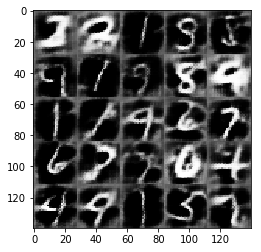

Epoch 2/2... Discriminator Loss: 1.6503... Generator Loss: 0.4351
Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 1.5151
Epoch 2/2... Discriminator Loss: 1.0101... Generator Loss: 1.5563
Epoch 2/2... Discriminator Loss: 1.0048... Generator Loss: 0.9865
Epoch 2/2... Discriminator Loss: 1.2792... Generator Loss: 0.6153
Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 2.2517
Epoch 2/2... Discriminator Loss: 1.2445... Generator Loss: 0.6679
Epoch 2/2... Discriminator Loss: 1.2979... Generator Loss: 0.5763
Epoch 2/2... Discriminator Loss: 0.9043... Generator Loss: 1.2679
Epoch 2/2... Discriminator Loss: 1.3403... Generator Loss: 0.5165
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


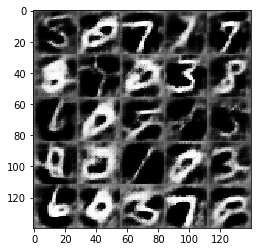

Epoch 2/2... Discriminator Loss: 0.8692... Generator Loss: 1.2912
Epoch 2/2... Discriminator Loss: 1.0342... Generator Loss: 2.0163
Epoch 2/2... Discriminator Loss: 1.1718... Generator Loss: 0.6846
Epoch 2/2... Discriminator Loss: 0.9753... Generator Loss: 1.1300
Epoch 2/2... Discriminator Loss: 1.8601... Generator Loss: 2.6156
Epoch 2/2... Discriminator Loss: 0.8785... Generator Loss: 1.3840
Epoch 2/2... Discriminator Loss: 0.8617... Generator Loss: 1.1115
Epoch 2/2... Discriminator Loss: 1.6069... Generator Loss: 0.4240
Epoch 2/2... Discriminator Loss: 0.7717... Generator Loss: 1.4766
Epoch 2/2... Discriminator Loss: 1.0337... Generator Loss: 1.4863
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


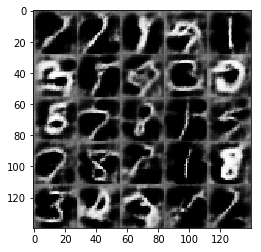

Epoch 2/2... Discriminator Loss: 0.9552... Generator Loss: 0.8865
Epoch 2/2... Discriminator Loss: 1.4617... Generator Loss: 0.4941
Epoch 2/2... Discriminator Loss: 1.2691... Generator Loss: 0.6188
Epoch 2/2... Discriminator Loss: 0.9900... Generator Loss: 0.9235
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 1.0356
Epoch 2/2... Discriminator Loss: 0.9211... Generator Loss: 1.0372
Epoch 2/2... Discriminator Loss: 0.9794... Generator Loss: 1.8207
Epoch 2/2... Discriminator Loss: 1.1946... Generator Loss: 0.6723
Epoch 2/2... Discriminator Loss: 0.9763... Generator Loss: 1.2865
Epoch 2/2... Discriminator Loss: 1.1104... Generator Loss: 2.1643
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


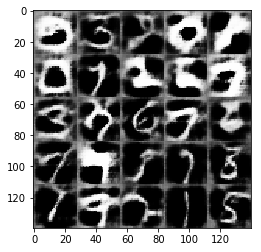

Epoch 2/2... Discriminator Loss: 1.4514... Generator Loss: 0.5467
Epoch 2/2... Discriminator Loss: 1.0351... Generator Loss: 1.5265
Epoch 2/2... Discriminator Loss: 1.0203... Generator Loss: 1.1909
Epoch 2/2... Discriminator Loss: 1.2647... Generator Loss: 0.6450
Epoch 2/2... Discriminator Loss: 1.1288... Generator Loss: 2.0885
Epoch 2/2... Discriminator Loss: 0.8493... Generator Loss: 1.3010
Epoch 2/2... Discriminator Loss: 1.0582... Generator Loss: 0.8123
Epoch 2/2... Discriminator Loss: 1.2406... Generator Loss: 0.6098
Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 0.5707
Epoch 2/2... Discriminator Loss: 0.6969... Generator Loss: 1.4137
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


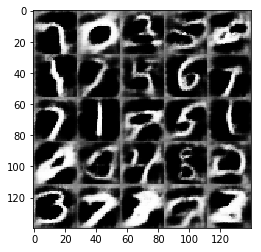

Epoch 2/2... Discriminator Loss: 1.4782... Generator Loss: 0.4432
Epoch 2/2... Discriminator Loss: 0.9109... Generator Loss: 1.1343
Epoch 2/2... Discriminator Loss: 0.7563... Generator Loss: 1.6217
Epoch 2/2... Discriminator Loss: 0.8778... Generator Loss: 1.1298
Epoch 2/2... Discriminator Loss: 0.7931... Generator Loss: 1.5968
Epoch 2/2... Discriminator Loss: 0.9461... Generator Loss: 0.9637
Epoch 2/2... Discriminator Loss: 0.8978... Generator Loss: 1.0420
Epoch 2/2... Discriminator Loss: 1.1005... Generator Loss: 1.2850
Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 0.5288
Epoch 2/2... Discriminator Loss: 1.1152... Generator Loss: 0.7746
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


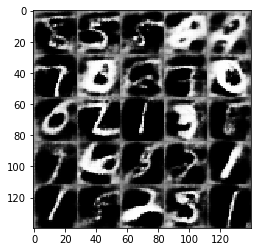

Epoch 2/2... Discriminator Loss: 1.2034... Generator Loss: 0.6508
Epoch 2/2... Discriminator Loss: 0.9670... Generator Loss: 1.0407
Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 0.9150
Epoch 2/2... Discriminator Loss: 1.2320... Generator Loss: 0.6289
Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 1.1710
Epoch 2/2... Discriminator Loss: 0.9070... Generator Loss: 0.9883
Epoch 2/2... Discriminator Loss: 1.2417... Generator Loss: 0.5790
Epoch 2/2... Discriminator Loss: 0.8986... Generator Loss: 0.9467
Epoch 2/2... Discriminator Loss: 1.5543... Generator Loss: 0.4703
Epoch 2/2... Discriminator Loss: 1.8058... Generator Loss: 0.3393
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


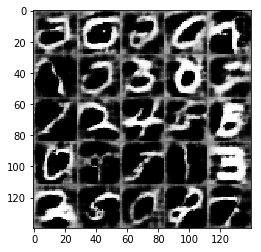

Epoch 2/2... Discriminator Loss: 1.1019... Generator Loss: 0.7479
Epoch 2/2... Discriminator Loss: 1.0526... Generator Loss: 0.8099
Epoch 2/2... Discriminator Loss: 1.9258... Generator Loss: 0.2761
Epoch 2/2... Discriminator Loss: 1.0541... Generator Loss: 1.4202
Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 0.5261
Epoch 2/2... Discriminator Loss: 0.9269... Generator Loss: 1.6803
Epoch 2/2... Discriminator Loss: 1.0173... Generator Loss: 0.8377
Epoch 2/2... Discriminator Loss: 1.6589... Generator Loss: 0.4341
Epoch 2/2... Discriminator Loss: 1.0499... Generator Loss: 0.7586
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.5887
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


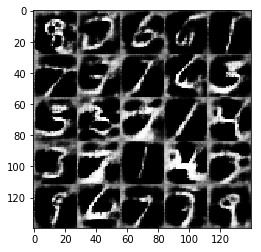

Epoch 2/2... Discriminator Loss: 1.5338... Generator Loss: 0.6638
Epoch 2/2... Discriminator Loss: 1.4517... Generator Loss: 0.4466
Epoch 2/2... Discriminator Loss: 0.9994... Generator Loss: 1.0445
Epoch 2/2... Discriminator Loss: 1.8233... Generator Loss: 0.3056
Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 0.6484
Epoch 2/2... Discriminator Loss: 1.0719... Generator Loss: 0.8801
Epoch 2/2... Discriminator Loss: 1.4278... Generator Loss: 0.4981


In [82]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
Epoch 1/1... Discriminator Loss: 2.8783... Generator Loss: 0.1204
Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 10.8653
Epoch 1/1... Discriminator Loss: 0.4036... Generator Loss: 5.1354
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.1364
Epoch 1/1... Discriminator Loss: 0.4133... Generator Loss: 5.7020
Epoch 1/1... Discriminator Loss: 0.4445... Generator Loss: 2.6925
Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 1.2378
Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 1.4922
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 4.5816
Epoch 1/1... Discriminator Loss: 0.5210... Generator Loss: 4.4869
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


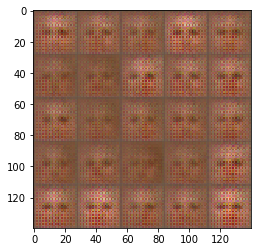

Epoch 1/1... Discriminator Loss: 0.7301... Generator Loss: 1.3723
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 8.8331
Epoch 1/1... Discriminator Loss: 0.5348... Generator Loss: 2.7448
Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 2.3770
Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 4.2438
Epoch 1/1... Discriminator Loss: 0.6660... Generator Loss: 1.4016
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.5495
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 2.8279
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


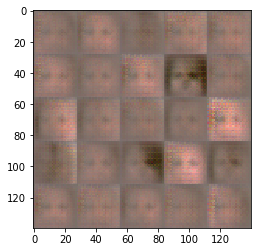

Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 1.3570
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 1.7599
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 2.6419
Epoch 1/1... Discriminator Loss: 2.0593... Generator Loss: 5.2612
Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 1.2432
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 2.0590
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 2.2585
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 2.1477
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.4847
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


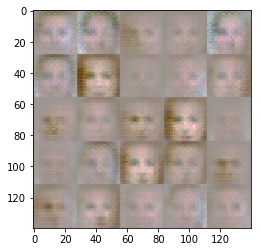

Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 1.6735
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 1.7041
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.9751
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 3.2289
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 1.7315... Generator Loss: 2.8085
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.3424
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


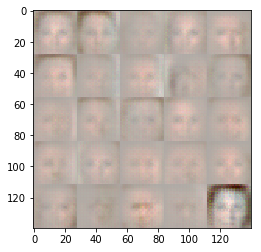

Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 1.3238
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.1461
Epoch 1/1... Discriminator Loss: 1.6277... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.4733
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.3471
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.2450
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.2728
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.2526
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


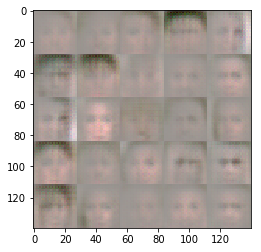

Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 1.4841
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.4803
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 1.5547
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 1.4221
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 1.6861
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.5864
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 2.8839
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


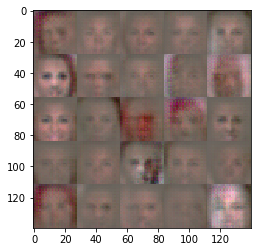

Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.3783
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 2.0695
Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 1.7186
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 2.0941
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 1.1914
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


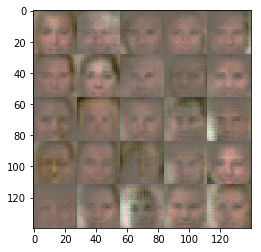

Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 1.2600
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.6503
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.5614
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 3.6259
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.0493
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


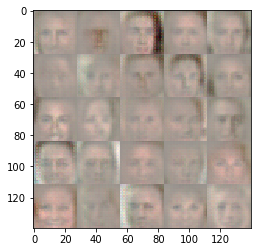

Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 1.2928
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 2.0679
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.9432
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 0.4006
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.6140
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


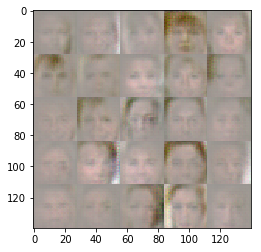

Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 1.2842
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 3.5612
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.4514
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 1.3363
Epoch 1/1... Discriminator Loss: 0.7637... Generator Loss: 1.3561
Epoch 1/1... Discriminator Loss: 1.9334... Generator Loss: 2.4920
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 1.7093
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.2298
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.9713
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 0.9464
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


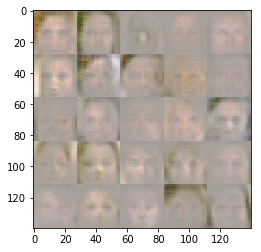

Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 1.2285
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.4366
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 1.2373
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 1.7174
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.1223
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.4912
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 1.3572
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


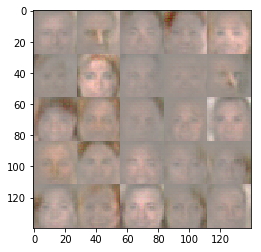

Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 1.3614
Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 1.6388
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 2.2229
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 1.5605
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 1.1499
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


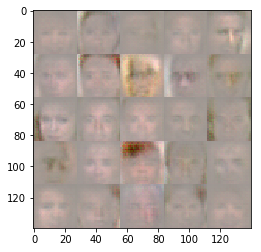

Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 1.1661
Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 2.5593
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 1.4387
Epoch 1/1... Discriminator Loss: 2.0169... Generator Loss: 2.9864
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 0.5926... Generator Loss: 1.9715
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 2.0457
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 1.2180
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


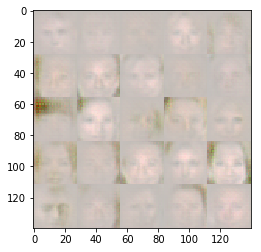

Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 1.3745
Epoch 1/1... Discriminator Loss: 1.6616... Generator Loss: 0.3557
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 1.1078
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 1.4067
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 0.7524... Generator Loss: 1.2529
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 0.9221
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


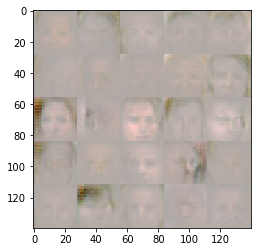

Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 1.3124
Epoch 1/1... Discriminator Loss: 1.8154... Generator Loss: 3.3977
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.6084
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.6105
Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 1.4129
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.4238
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)
LRELU1 (?, 4, 4, 512)
LRELU2 (?, 7, 7, 256)
LRELU3 (?, 14, 14, 128)
LRELU4 (?, 28, 28, 64)


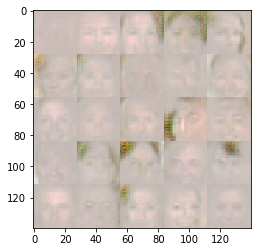

Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.1471
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.7388
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 2.7266
Epoch 1/1... Discriminator Loss: 0.8963... Generator Loss: 2.0351
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 1.3996


In [83]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.